# FULL DATA INTERPRETATION

### In this notebook I´ll apply the code that I tested in the Initial Data interpretation notebook, with the whole dataset 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format #So the numbers will not appear in a scientific format

- Concatenation of the 3 datasets that shows the data of the last 9 months, from October to July. 

*It´ll be updated with the data until September later on

In [7]:
chunk1=pd.read_csv("Data From October 2019 to Jan 2020.csv", thousands='.',parse_dates=['Time'])
chunk2=pd.read_csv("Data From Jan to April 2020.csv", thousands='.',parse_dates=['Time'])
chunk3=pd.read_csv("Data From April to July 2020.csv", thousands='.',parse_dates=['Time'])
print(chunk1.shape, chunk2.shape, chunk3.shape)

(185523, 22) (222676, 22) (241940, 22)


In [8]:
data = pd.concat([chunk1,chunk2,chunk3])
data.shape

(650139, 22)

In [9]:
data.isnull().sum()

Time                                     0
Domain                                 275
Opportunities                            0
Format Loads                         28164
Format Fill Rate                     28164
Impressions                              0
Viewable Impressions                     0
Viewability Measured Impressions         0
Viewability Rate                    334524
Fill Rate                                0
Efficiency Rate                          0
CPM                                      0
Cost                                     0
Profit                                   0
Revenue                                  0
Profit Margin                            0
Clicks                                   0
CTR                                      0
25% View Rate                            0
50% View Rate                            0
75% View Rate                            0
100% View Rate                           0
dtype: int64

I drop all the Domains that don´t have info about the format Loads and the Domain. With the filters I´ll apply later the
Null values of the Viewability Rate will be rejected

In [10]:
data = data.dropna(subset =['Format Loads','Format Fill Rate', 'Domain'])

- 1: Dropping the columns that don´t add value to the advertisers
- 2: Converting numeric columns with ' , ' into integers
- 3: Converting columns with '%' , '$' and ',' into floats

In [11]:
#1
data.drop(['Opportunities','Viewable Impressions','Viewability Measured Impressions','Fill Rate', 'Cost','Profit','Revenue','Profit Margin'],axis=1, inplace=True)

#2
data['Format Loads'] = data['Format Loads'].str.replace(",", "").astype(int)
data['Impressions'] = data['Impressions'].str.replace(",", "").astype(int)
data['Clicks'] = data['Clicks'].str.replace(",", "").astype(int)

#3
data['Format Fill Rate'] = data['Format Fill Rate'].str.replace("%", "").astype(float)
data['Viewability Rate'] = data['Viewability Rate'].str.replace("%", "").astype(float).fillna(0)
data['Efficiency Rate'] = data['Efficiency Rate'].str.replace("%", "").astype(float)
data['CPM'] = data['CPM'].str.replace("$", "").astype(float)
data['CTR'] = data['CTR'].str.replace("%", "").astype(float)
data['25% View Rate'] = data['25% View Rate'].str.replace("%", "").astype(float)
data['50% View Rate'] = data['50% View Rate'].str.replace("%", "").astype(float)
data['75% View Rate'] = data['75% View Rate'].str.replace("%", "").astype(float)
data['100% View Rate'] = data['100% View Rate'].str.replace("%", "").astype(float)

In [12]:
data.isnull().sum()

Time                0
Domain              0
Format Loads        0
Format Fill Rate    0
Impressions         0
Viewability Rate    0
Efficiency Rate     0
CPM                 0
Clicks              0
CTR                 0
25% View Rate       0
50% View Rate       0
75% View Rate       0
100% View Rate      0
dtype: int64

In [13]:
print(len(data['Domain'].unique()))
print(data.shape)


19129
(621700, 14)


### **I´ll keep the rows with more than 70000 Format Loads. It´s the filter to consider a domain representative**


In [14]:
data = data[data['Format Loads']>70000]
print(len(data['Domain'].unique()))
print(data.shape)

818
(60637, 14)


- **We have 818 Domains**

- I´m going to create the DataFrame that I´ll use later to apply the K-Means Algorithm and divide the Domains into differente clusters, grouping by Domain, and calculating the mean of each variable based on the daily data of the last 9 months

In [15]:
groupby_domains = data.groupby(['Domain']).agg({'Format Loads':np.mean,
                                'Impressions':np.mean,
                                'Format Fill Rate':np.mean,
                                'Viewability Rate':np.mean,
                                'Efficiency Rate':np.mean,
                                'CPM':np.mean,
                                'Clicks':np.mean,
                                'CTR':np.mean,
                                '25% View Rate':np.mean,
                                '50% View Rate':np.mean,
                                '75% View Rate':np.mean,
                                '100% View Rate':np.mean
                                }).sort_values( by= 'Format Loads',ascending=False).reset_index()
print(groupby_domains.shape)

(818, 13)


# NEW VARIABLES

### ADDING THE CATEGORY OF THE DOMAIN THROUGH A NEW TABLE

In [16]:
categories = pd.read_csv('Index Exchange Quality Inventory Mapping - Existing Acccount-Reseller-Domains - Compliance (1).csv')
categories.columns = ['Unnamed: 0', 'Partner/Seller Name', 'Partner/Seller ID',
       'Inventory Relationship\n(select from dropdown)', 'Domain',
       'Category', 'Monthly Volume', 'Ad Formats',
       'Banner/Player Dimensions']

print(len(categories['Category'].unique()), 'categories')

import re
pattern = '>'
renamed_categories = []
for string in categories['Category']:
    text = string
    match = re.search(pattern, text)
    s = match.start()
    renamed_categories.append(string[:s])
categories['Category'] = categories['Category'].replace(categories['Category'].values, renamed_categories )
categories['Category'] = categories['Category'].map(lambda x: x.strip()) # to reomve the blank space in the end of the strings

print(len(categories['Category'].unique()))

52 categories
19


In [17]:
categories_importance = pd.DataFrame(categories.groupby('Category')['Monthly Volume'].sum().sort_values(ascending=False).reset_index())

total_formatloads = categories_importance['Monthly Volume'].sum()
categories_importance['Category importance'] = categories_importance['Monthly Volume'].apply(lambda x: x/total_formatloads)

domains_categories_importance = categories.merge(categories_importance, on='Category')
domains_categories_importance = domains_categories_importance[['Domain','Category','Category importance']]

In [15]:
data = data.merge(domains_categories_importance, on='Domain', how='left')
display(data.head(5))
data.isnull().sum()

,Time,Domain,Format Loads,Format Fill Rate,Impressions,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,25% View Rate,50% View Rate,75% View Rate,100% View Rate,Category,Category importance
0,2019-10-01,riovagas.com.br,617493,0.57,3524,52.04,99.66,1.62,11,0.31,65.55,58.20,53.63,48.86,News & Portals,0.59
1,2019-10-01,ilustrado.cl,111369,16.50,18375,93.24,99.74,1.60,523,2.85,81.12,71.43,63.59,56.15,News & Portals,0.59
2,2019-10-01,limanowa.in,75407,0.95,718,88.24,98.63,1.58,2,0.28,82.31,71.73,63.93,58.77,NaN,nan
3,2019-10-01,applealmond.com,97442,15.07,14681,80.93,99.98,1.98,33,0.22,82.89,71.53,64.37,58.64,NaN,nan
4,2019-10-01,tempo.co,818259,0.36,2926,84.68,97.02,1.72,19,0.65,81.34,73.86,68.11,63.09,News & Portals,0.59


Time                       0
Domain                     0
Format Loads               0
Format Fill Rate           0
Impressions                0
Viewability Rate           0
Efficiency Rate            0
CPM                        0
Clicks                     0
CTR                        0
25% View Rate              0
50% View Rate              0
75% View Rate              0
100% View Rate             0
Category               16001
Category importance    16001
dtype: int64

In [16]:
groupby_domains = groupby_domains.merge(domains_categories_importance, on='Domain', how ='left')
display(groupby_domains.head(5))
groupby_domains.isnull().sum()

,Domain,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,25% View Rate,50% View Rate,75% View Rate,100% View Rate,Category,Category importance
0,memurlar.net,2849893.77,9517.08,0.72,83.57,91.96,1.58,48.92,0.49,78.32,66.98,59.03,52.54,Health & Wellness,0.02
1,missyusa.com,2421029.77,152692.65,8.35,77.46,98.25,1.71,125.82,0.08,74.68,60.76,51.52,44.55,News & Portals,0.59
2,1news.com.br,2149754.21,301154.43,13.62,88.50,99.56,1.62,1278.98,0.44,91.91,87.12,82.62,74.32,NaN,nan
3,bitbol.la,1186814.67,38132.18,3.70,90.56,93.34,1.50,162.41,0.40,81.16,70.75,62.21,53.26,NaN,nan
4,plantaoaovivo.com.br,1171509.48,37095.63,2.89,91.65,96.04,1.62,241.97,1.06,84.00,75.06,67.18,60.36,Community & Culture,0.07


Domain                   0
Format Loads             0
Impressions              0
Format Fill Rate         0
Viewability Rate         0
Efficiency Rate          0
CPM                      0
Clicks                   0
CTR                      0
25% View Rate            0
50% View Rate            0
75% View Rate            0
100% View Rate           0
Category               393
Category importance    393
dtype: int64

## **The new table is not updated and there are 393 domains that are not on it. I consider the Category column could add value to the final model, so I don´t want NANs on it. Because of that I´m gonna manually introduce the category in the Domains without it to have this column filled, and then I´ll merge this with the main DataFrame**

- 1: Reading the dataframe with the Nans manually added
- 2: Adding to this dataframe the category importance columns
- 3: Merging with the dataframe with the domains that didn´t have null category

In [18]:
#1 
groupby_domains_NANs_corrected = pd.read_csv('groupby_domains_NANs_allcorrected.csv')
groupby_domains_NANs_corrected.drop('Unnamed: 0', axis=1, inplace=True)

#2
groupby_domains_NANs_corrected = groupby_domains_NANs_corrected.merge(categories_importance, on='Category')
groupby_domains_NANs_corrected = groupby_domains_NANs_corrected[['Domain','Category','Category importance']]

#3
categories_by_importance_complete = domains_categories_importance.merge(groupby_domains_NANs_corrected, how = 'outer')


In [19]:
data = data.merge(categories_by_importance_complete, on='Domain', how='left')
data = data.set_index('Time')
display(data.head(5))
data.isnull().sum()

,Domain,Format Loads,Format Fill Rate,Impressions,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,25% View Rate,50% View Rate,75% View Rate,100% View Rate,Category,Category importance
Time,,,,,,,,,,,,,,,
2019-10-01,riovagas.com.br,617493,0.57,3524,52.04,99.66,1.62,11,0.31,65.55,58.20,53.63,48.86,News & Portals,0.59
2019-10-01,ilustrado.cl,111369,16.50,18375,93.24,99.74,1.60,523,2.85,81.12,71.43,63.59,56.15,News & Portals,0.59
2019-10-01,limanowa.in,75407,0.95,718,88.24,98.63,1.58,2,0.28,82.31,71.73,63.93,58.77,News & Portals,0.59
2019-10-01,applealmond.com,97442,15.07,14681,80.93,99.98,1.98,33,0.22,82.89,71.53,64.37,58.64,Tech & Gaming,0.02
2019-10-01,tempo.co,818259,0.36,2926,84.68,97.02,1.72,19,0.65,81.34,73.86,68.11,63.09,News & Portals,0.59


Domain                 0
Format Loads           0
Format Fill Rate       0
Impressions            0
Viewability Rate       0
Efficiency Rate        0
CPM                    0
Clicks                 0
CTR                    0
25% View Rate          0
50% View Rate          0
75% View Rate          0
100% View Rate         0
Category               0
Category importance    0
dtype: int64

In [20]:
groupby_domains = groupby_domains.merge(categories_by_importance_complete, on='Domain', how ='left')
display(groupby_domains.head(5))
groupby_domains.isnull().sum()

,Domain,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,25% View Rate,50% View Rate,75% View Rate,100% View Rate,Category,Category importance
0,memurlar.net,2849893.77,9517.08,0.72,83.57,91.96,1.58,48.92,0.49,78.32,66.98,59.03,52.54,Health & Wellness,0.02
1,missyusa.com,2421029.77,152692.65,8.35,77.46,98.25,1.71,125.82,0.08,74.68,60.76,51.52,44.55,News & Portals,0.59
2,1news.com.br,2149754.21,301154.43,13.62,88.50,99.56,1.62,1278.98,0.44,91.91,87.12,82.62,74.32,News & Portals,0.59
3,bitbol.la,1186814.67,38132.18,3.70,90.56,93.34,1.50,162.41,0.40,81.16,70.75,62.21,53.26,Sports,0.08
4,plantaoaovivo.com.br,1171509.48,37095.63,2.89,91.65,96.04,1.62,241.97,1.06,84.00,75.06,67.18,60.36,Community & Culture,0.07


Domain                 0
Format Loads           0
Impressions            0
Format Fill Rate       0
Viewability Rate       0
Efficiency Rate        0
CPM                    0
Clicks                 0
CTR                    0
25% View Rate          0
50% View Rate          0
75% View Rate          0
100% View Rate         0
Category               0
Category importance    0
dtype: int64

In [24]:
groupby_domains = groupby_domains.drop_duplicates(subset=['Domain'], keep='first').reset_index(drop=True)
groupby_domains.shape

(818, 15)

In [26]:
data.to_csv('Global Report.csv', index=True)
groupby_domains.to_csv('Global groupby_domains.csv', index=False)

### ADDING A COLUMN TO REPRESENT IF IT´S A RECURRENT DOMAIN, WITH FOUR DIFFERENT LEVELS 

We have 9 months available:

- Very recurrent Domain: more than 8 months -> 3
- Recurrent Domain: between 4-8 months -> 2
- No recurrent Domain: between 2-4 months -> 1
- Residual Domain: betwwen 0-2 months -> 0


In [27]:
report = pd.read_csv('Global Report.csv',index_col =['Time'])
groupby_domains = pd.read_csv('Global groupby_domains.csv')

In [30]:
#Creating a Dataframe with the number of days that each domain appears
recurrence = pd.DataFrame(report['Domain'].value_counts()).reset_index()
recurrence.columns = ['Domain', 'Recurrence']

#List comprehension to assign the levels based on the number of days
recurrence['Domain Recurrence'] = [3 if x>=240 else (2 if 120<=x<240 else(1 if 60<x<120 else 0)) for x in recurrence['Recurrence']]
recurrence = recurrence[['Domain', 'Domain Recurrence']]

#Adding the column to the main Dataframe
report = report.reset_index().merge(recurrence, on='Domain', how='left').set_index('Time') 
groupby_domains = groupby_domains.merge(recurrence, on='Domain', how='left')

In [31]:
recurrence['Domain Recurrence'].value_counts()

0    492
2    144
1    124
3     58
Name: Domain Recurrence, dtype: int64

In [33]:
report.to_csv('Global Report.csv',index=True)
groupby_domains.to_csv('Global groupby_domains.csv', index=False)

In [36]:
report = pd.read_csv('Global Report.csv', index_col=['Time'])
groupby_domains = pd.read_csv('Global groupby_domains.csv')

## RELATIONSHIP BETWEEN VARIABLES

In [45]:
groupby_domains.corr(method = 'pearson')

,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,25% View Rate,50% View Rate,75% View Rate,100% View Rate,Category importance,Domain Recurrence
Format Loads,1.00,0.50,-0.03,-0.03,0.01,-0.01,0.36,-0.03,0.01,0.01,-0.00,-0.01,0.05,0.27
Impressions,0.50,1.00,0.64,0.05,0.14,-0.02,0.77,-0.02,0.16,0.19,0.20,0.20,0.04,0.33
Format Fill Rate,-0.03,0.64,1.00,0.11,0.20,-0.03,0.44,-0.01,0.21,0.25,0.27,0.28,-0.02,0.15
Viewability Rate,-0.03,0.05,0.11,1.00,0.51,0.16,0.11,0.30,0.67,0.56,0.49,0.44,0.19,-0.01
Efficiency Rate,0.01,0.14,0.20,0.51,1.00,0.43,0.10,0.11,0.56,0.46,0.41,0.38,0.11,0.10
CPM,-0.01,-0.02,-0.03,0.16,0.43,1.00,-0.07,-0.08,0.19,0.16,0.14,0.13,0.07,-0.01
Clicks,0.36,0.77,0.44,0.11,0.10,-0.07,1.00,0.29,0.12,0.13,0.13,0.12,0.09,0.27
CTR,-0.03,-0.02,-0.01,0.30,0.11,-0.08,0.29,1.00,0.06,0.00,-0.03,-0.04,0.14,0.04
25% View Rate,0.01,0.16,0.21,0.67,0.56,0.19,0.12,0.06,1.00,0.96,0.92,0.88,0.18,0.10
50% View Rate,0.01,0.19,0.25,0.56,0.46,0.16,0.13,0.00,0.96,1.00,0.99,0.96,0.18,0.11


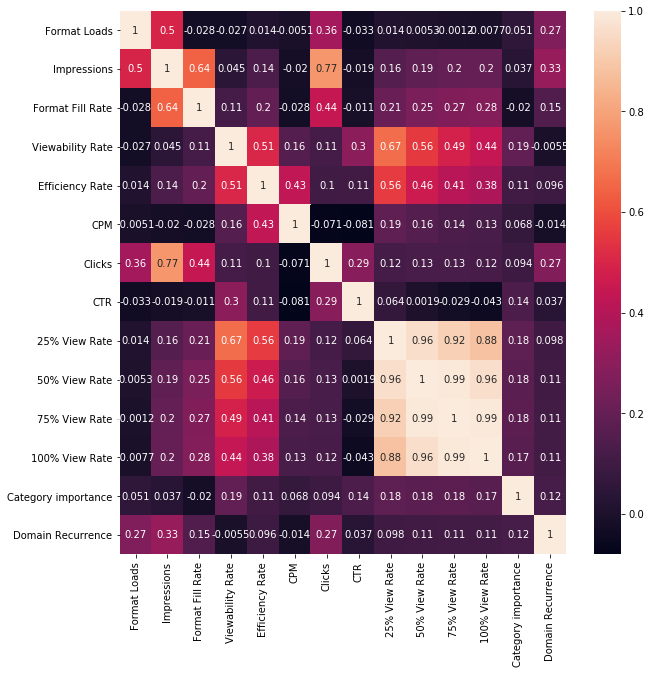

In [46]:
plt.rcParams['figure.figsize']=(10,10)
sns.heatmap(groupby_domains.corr(), annot = True)

- **Only the variables about the View Rate percentages are strongly correlated (more than 90%). I´ll  convert these 4 variables into only one**
- I decide to only keep the 50% View Rate column. The reason is that the mean variation between the 25% View Rate column and the 50% View Rate column is around 8%, and the mean variation between the 25% View Rate column and the 50% View Rate column is around 11%, so the 50% View Rate column gives the best representation to know in which View Rate ranges the domains are

In [39]:
report.drop(['25% View Rate','75% View Rate','100% View Rate'],axis=1, inplace=True)
groupby_domains.drop(['25% View Rate','75% View Rate','100% View Rate'],axis=1, inplace = True)

In [40]:
report.to_csv('Global Report.csv',index=True)
groupby_domains.to_csv('Global groupby_domains.csv', index=False)

# ANALIZING EACH VARIABLE

In [33]:
groupby_domains.head(1)

,Domain,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,25% View Rate,50% View Rate,75% View Rate,100% View Rate,Category,Category importance,Domain Recurrence
0,memurlar.net,2849893.77,9517.08,0.72,83.57,91.96,1.58,48.92,0.49,78.32,66.98,59.03,52.54,Health & Wellness,0.02,1


### Format Loads: traffic generated by each domain

(array([726.,  64.,  17.,   7.,   1.,   0.,   0.,   1.,   1.,   1.]),
 array([  70783.        ,  348694.07717391,  626605.15434783,
         904516.23152174, 1182427.30869565, 1460338.38586957,
        1738249.46304348, 2016160.54021739, 2294071.6173913 ,
        2571982.69456522, 2849893.77173913]),
 <a list of 10 Patch objects>)

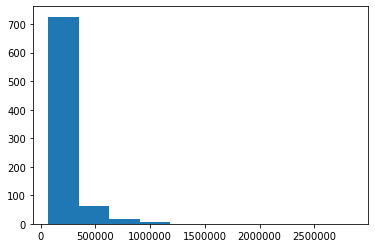

In [9]:
plt.hist(groupby_domains['Format Loads'])

In [ ]:
plt.scatter(groupby_domains['Domain'], groupby_domains['Format Loads'])

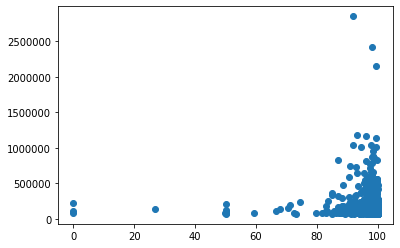

In [11]:
plt.scatter(groupby_domains['Efficiency Rate'], groupby_domains['Format Loads']);

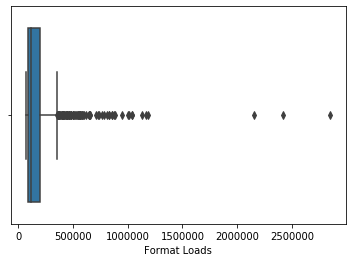

In [34]:
sns.boxplot(groupby_domains['Format Loads'])

In [35]:
groupby_domains['Format Loads'].describe()

count       825.00
mean     190562.66
std      214457.35
min       70783.00
25%       92107.93
50%      119842.00
75%      197790.17
max     2849893.77
Name: Format Loads, dtype: float64

In [36]:
report[report['Domain']=='mundopositivo.com.br'].describe()

,Format Loads,Format Fill Rate,Impressions,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,25% View Rate,50% View Rate,75% View Rate,100% View Rate,Category importance,Domain Recurrence
count,275.00,275.00,275.00,275.00,275.00,275.00,275.00,275.00,275.00,275.00,275.00,275.00,275.00,275.00
mean,1039078.48,14.70,81984.35,73.54,97.84,1.81,9.39,0.03,87.24,91.12,89.25,85.10,0.07,3.00
std,428414.59,38.59,159343.40,8.12,6.06,0.42,16.64,0.04,7.59,5.71,6.21,6.83,0.00,0.00
min,129272.00,0.02,255.00,49.51,37.85,1.50,0.00,0.00,62.47,61.47,59.41,57.36,0.07,3.00
25%,797419.00,0.94,11037.50,68.36,98.93,1.59,1.00,0.00,81.94,90.43,87.74,82.80,0.07,3.00
50%,1006485.00,2.54,26991.00,73.00,99.72,1.64,4.00,0.01,89.97,92.39,90.33,86.40,0.07,3.00
75%,1302226.50,8.94,68202.50,78.88,99.91,1.85,10.00,0.03,93.53,93.89,92.78,89.30,0.07,3.00
max,1935633.00,294.20,1101867.00,90.53,100.00,4.98,139.00,0.26,98.03,97.58,97.45,96.45,0.07,3.00


### Impressions: times that the add had appeared to any user in each domain

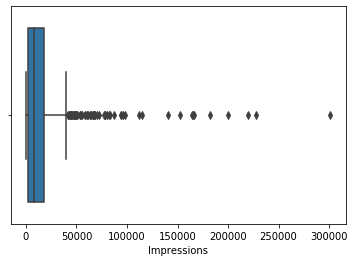

In [37]:
sns.boxplot(groupby_domains['Impressions'])

In [38]:
groupby_domains['Impressions'].describe()

count      825.00
mean     15396.50
std      26181.17
min          0.00
25%       2519.07
50%       7761.33
75%      17929.50
max     301154.43
Name: Impressions, dtype: float64

In [39]:
groupby_domains[groupby_domains['Impressions']<10000] 

,Domain,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,25% View Rate,50% View Rate,75% View Rate,100% View Rate,Category,Category importance,Domain Recurrence
0,memurlar.net,2849893.77,9517.08,0.72,83.57,91.96,1.58,48.92,0.49,78.32,66.98,59.03,52.54,Health & Wellness,0.02,1
16,bgr.in,825563.60,6948.47,1.15,81.77,87.05,1.63,5.43,0.28,81.49,73.03,65.91,57.05,Tech & Gaming,0.02,0
26,ask.fm,648093.09,6729.94,1.03,64.47,93.11,1.83,4.01,0.07,78.42,70.36,64.77,60.23,News & Portals,0.59,3
27,botasot.info,644915.34,4711.15,0.72,91.55,95.50,1.67,49.30,1.05,87.14,78.95,72.77,63.73,News & Portals,0.59,1
30,lebanonfiles.com,596280.31,3038.63,0.49,73.14,90.43,1.78,17.62,0.52,79.92,70.98,65.24,60.55,News & Portals,0.59,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,rawicz24.pl,71956.00,8.00,0.01,100.00,100.00,1.52,0.00,0.00,100.00,87.50,87.50,75.00,News & Portals,0.59,0
820,dondeir.com,71861.00,3841.00,5.35,82.83,100.00,1.88,45.00,1.17,76.44,61.83,53.19,46.00,Travel,0.00,0
821,quinto-poder.mx,71386.00,224.00,0.31,88.29,94.12,2.24,1.00,0.45,81.25,74.55,67.41,62.95,News & Portals,0.59,0
822,cn7.com.br,71366.00,6115.00,8.57,82.32,99.87,1.63,89.00,1.46,83.65,72.40,64.58,58.41,News & Portals,0.59,0


### Format Fill Rate

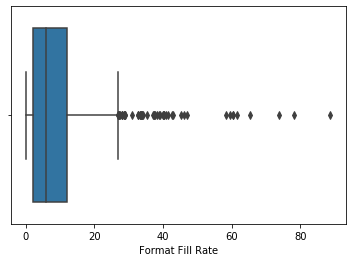

In [40]:
sns.boxplot(groupby_domains['Format Fill Rate'])

In [41]:
groupby_domains['Format Fill Rate'].describe()

count   825.00
mean      9.04
std      10.78
min       0.00
25%       1.95
50%       5.78
75%      11.94
max      88.77
Name: Format Fill Rate, dtype: float64

In [42]:
groupby_domains[groupby_domains['Format Fill Rate']>50]

,Domain,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,25% View Rate,50% View Rate,75% View Rate,100% View Rate,Category,Category importance,Domain Recurrence
81,mundohispanico.com,371914.32,219450.27,61.48,85.15,98.52,1.66,1638.63,0.79,87.18,80.58,75.04,69.99,News & Portals,0.59,3
181,minhavida.com.br,221929.52,164143.81,73.85,87.40,99.91,1.75,897.36,0.56,88.29,82.77,78.33,73.10,Health & Wellness,0.02,2
301,ibtimes.co.in,146522.00,114621.00,78.23,92.81,99.57,2.30,2.00,0.00,97.54,97.07,96.60,96.19,News & Portals,0.59,0
429,viomundo.com.br,116427.19,78444.25,58.37,93.96,99.92,1.64,281.81,0.72,90.95,86.74,82.59,75.83,News & Portals,0.59,0
464,guiadacozinha.com.br,111043.97,67352.38,60.41,82.45,99.07,1.62,426.85,0.74,84.11,76.36,70.65,65.46,Food,0.01,1
465,guiadacozinha.com.br,111043.97,67352.38,60.41,82.45,99.07,1.62,426.85,0.74,84.11,76.36,70.65,65.46,Food,0.01,1
540,designyoutrust.com,100762.20,67126.40,65.39,89.72,95.38,1.72,323.50,0.51,82.79,74.87,69.91,65.94,Community & Culture,0.07,0
626,finanzmarktwelt.de,91277.28,53839.06,59.38,89.57,98.61,1.57,319.46,0.60,89.89,83.41,78.13,72.79,Money & Investing,0.01,0
634,nsctotal.com.br,90639.00,80220.00,88.77,91.98,99.97,1.59,248.50,0.32,89.38,84.69,80.28,75.14,News & Portals,0.59,0


In [43]:
report[report['Format Fill Rate']>100].shape

(266, 17)

There are some cases where the Format Fill Rate can be more than 100%, that means more Impressions than Format Loads. It´s not a mistake, it can happen for example with agressive campaigns

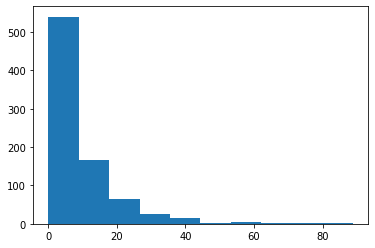

In [44]:
plt.hist(groupby_domains['Format Fill Rate']);

### UNDERSTANDING THE DATA WITH GRAPHS

### General shape of the Format Loads and Impressions over the 3 months:

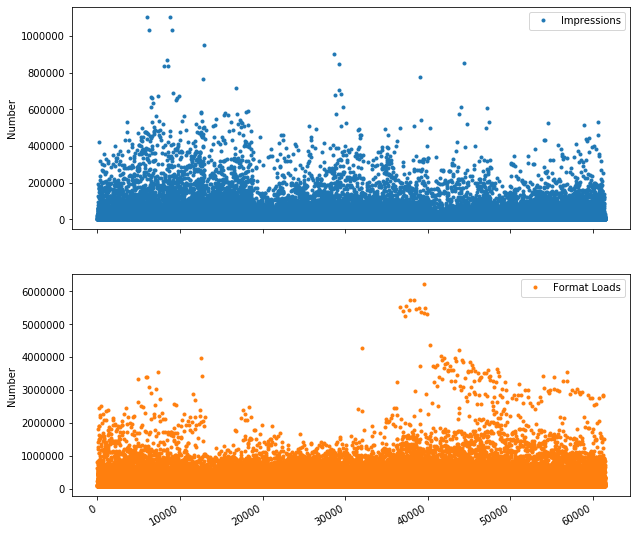

In [47]:
col_graf = ['Impressions', 'Format Loads'] 
ejes = report[col_graf].plot(marker='.', linestyle='None',figsize=(10,10),subplots=True)
for eje in ejes:
  eje.set_ylabel('Number')

### Distribution of the categories

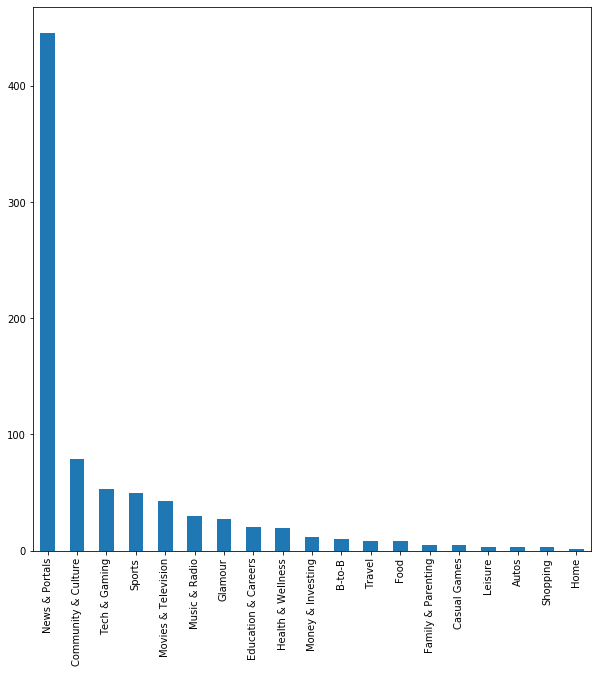

In [48]:
categories=groupby_domains['Category'].value_counts()
categories.plot(kind='bar');

### Impressions evolution through the three months

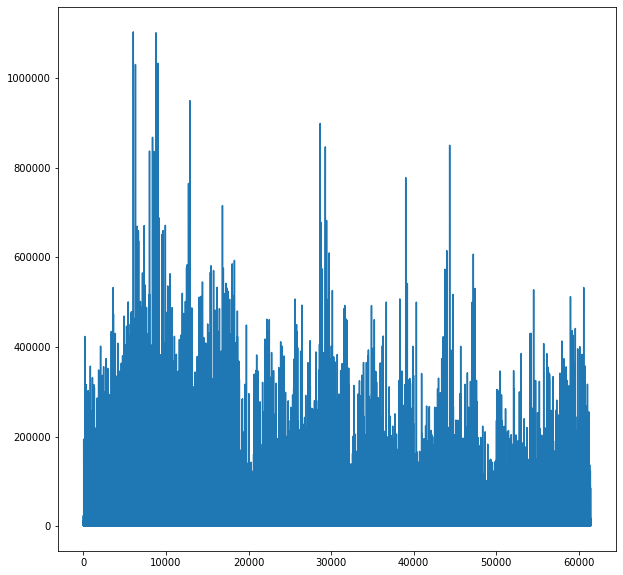

In [49]:
report.groupby(report.index)['Impressions'].sum().plot(kind='line', rot = 0)

### Number of recurrent Domains

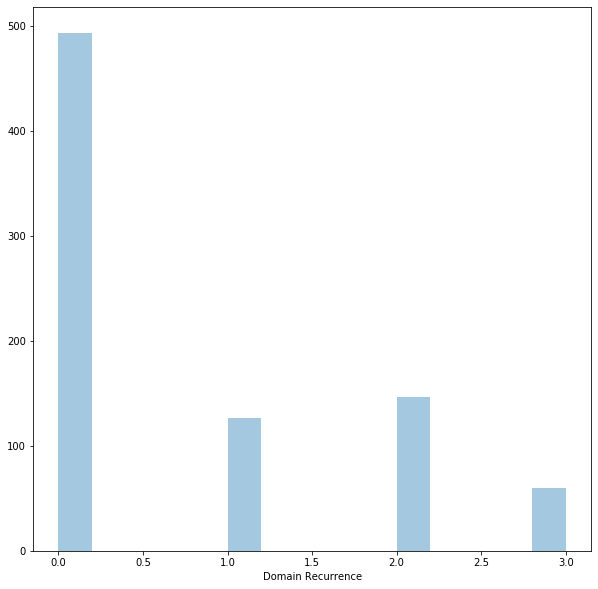

In [50]:
sns.distplot(groupby_domains['Domain Recurrence'], kde = False);

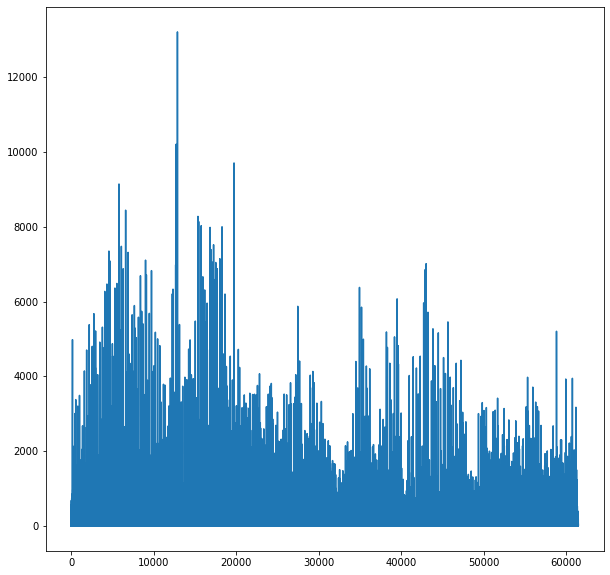

In [51]:
plt.rcParams['figure.figsize']=(10,10)
report.Clicks.plot(kind= 'line')

In [52]:
ffr_bycategories = pd.DataFrame(report.groupby(['Time', 'Category'])['Format Fill Rate'].mean()).reset_index()

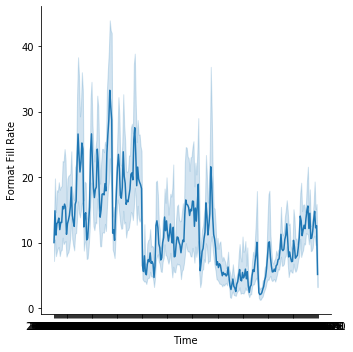

In [53]:
sns.relplot(x="Time", y='Format Fill Rate', kind="line", data=ffr_bycategories)